Things to check:
1. $\chi^2$ histogram
2. Error histogram
3. Residuals histogram for individual runs
4. Look at longer run

In [245]:
%load_ext autoreload
%autoreload
import sys, os
import numpy as np
import scipy.optimize as optimize
import scipy.fftpack as fft
import scipy.linalg as linalg
from scipy.stats import chisquare
from scipy.stats import linregress

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from BandPass2 import *
from fitFunctions import *
from partialfitting import *
from tqdm import *

import allantools

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 15

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
dirName = "/home/jean/RomalisResearch/ncrescini/18-10-30 1/" # Directory with data
#dirName = "/home/jean/RomalisResearch/FakeData/18-12-10/" # Directory with data
files = [f for f in os.listdir(dirName) if f.endswith('.txt')]
gHe = 20378.9
gNe = 2*np.pi*336.1
gRatio = gHe/gNe

ks1 = 3 # First file index
ks2 = 38 # Last file index
n_ave = 10 # Number of points to average over

dt = 1e-3*n_ave
Fs = 1/dt
D1Start = 50 # Start of first detection (currently only uses this)
D1EndTimes = [95] # End of first detection (currently only uses this)
D2Start = 200 # Start of second detection (currently doesn't use this)
D2EndTimes = [240] # End of second detection (currently doesn't use this)
curve_fit = True # Use curve_fit or scipy minimize
calcJac = False # Calculate jacobian by hand or extract errors/jacobian from fitter (curve_fit/scipy minimize)
absSigma = True

delta_t_arr = [2/1.56] # Number of subsections to break the detection period into

In [247]:
for delta_t in delta_t_arr:
    fout = []
    ferr = []
    chi2 = []
    corrphase_arr = []
    corrphaseerr_arr = []
    corrphasechi2_arr = []
    phi1_arr_all = []
    phi2_arr_all = []
    r_arr = []
    for k_ind in range(ks1, ks2+1):
        print(k_ind)
        k = k_ind + ks1 - 1 # file number
        paraOut_arr, errtout_arr, dataPar_x, dataPar_y, datafit = partialfitting(k_ind, k, n_ave, dirName, files, dt, Fs, D1Start, D1EndTimes, D2Start, D2EndTimes, curve_fit, calcJac, delta_t)
        phi1_arr, phi2_arr, fit_freq1, fit_freq2, fit_err1, fit_err2 = correctPhases(paraOut_arr, errtout_arr, dataPar_x, dataPar_y)
        phi1_fit = linregress( np.mean(dataPar_x, axis=1), phi1_arr )
        phi1_fit, phi1_cov = optimize.curve_fit( lambda x, a, b: a*x+b, np.mean(dataPar_x, axis=1), phi1_arr, p0=[phi1_fit[0], phi1_fit[1]], sigma=errtout_arr[:,5], bounds=([.5*phi1_fit[0], .5*phi1_fit[1]], [1.5*phi1_fit[0], 1.5*phi1_fit[1]]), absolute_sigma=absSigma )
        phi1_err = np.sqrt(np.diag(phi1_cov))
        phi2_fit = linregress( np.mean(dataPar_x, axis=1), phi2_arr )
        phi2_fit, phi2_cov = optimize.curve_fit( lambda x, a, b: a*x+b, np.mean(dataPar_x, axis=1), phi2_arr, p0=[phi2_fit[0], phi2_fit[1]], sigma=errtout_arr[:,2], absolute_sigma=absSigma )
        phi2_err = np.sqrt(np.diag(phi2_cov))
        r_fit, r_cov = optimize.leastsq( lambda p: phi1_arr-p[0]*phi2_arr-p[1], [gHe/gNe, 0.01] )
        r = r_fit[0]
        r_arr.append(r)
        corrphase_fit, corrphase_cov = optimize.curve_fit( lambda x, a, b: a*x+b, np.mean(dataPar_x, axis=1), phi1_arr - r*phi2_arr, p0=[1e-10, 0.1], sigma=np.sqrt(errtout_arr[:,5]**2 + (errtout_arr[:,2]*r)**2 ), absolute_sigma=absSigma)
        corrphase_err = np.sqrt(np.diag(corrphase_cov))
        corrphase_arr.append(np.array(corrphase_fit))
        corrphaseerr_arr.append(np.array(corrphase_err))
        corrphasechi2_arr.append(np.sum((corrphase_fit[1] + np.mean(dataPar_x, axis=1)*corrphase_fit[0]-(phi1_arr - r*phi2_arr))**2/(errtout_arr[:,5]**2 + (errtout_arr[:,2]*r)**2 )/(len(phi1_arr)-2)))
        
        fout.append([phi1_fit[0], phi2_fit[0]])
        ferr.append([phi1_err[0], phi2_err[0]])
        
        phi1_arr_all.append(phi1_arr)
        phi2_arr_all.append(phi2_arr)
        
        chi2_1 = np.sum((phi1_fit[1] + np.mean(dataPar_x, axis=1)*phi1_fit[0]-phi1_arr)**2/(errtout_arr[:,5])**2/(len(phi1_arr)-2))
        chi2_2 = np.sum((phi2_fit[1] + np.mean(dataPar_x, axis=1)*phi2_fit[0]-phi2_arr)**2/(errtout_arr[:,2])**2/(len(phi2_arr)-2))
        chi2.append([chi2_1, chi2_2])

    corrphase_arr = np.array(corrphase_arr)
    corrphaseerr_arr = np.array(corrphaseerr_arr)
    correphasechi2_arr = np.array(corrphasechi2_arr)
    r_arr = np.array(r_arr)
    fout = np.array(fout)
    ferr = np.array(ferr)
    phi1_arr_all = np.array(phi1_arr_all)
    phi2_arr_all = np.array(phi2_arr_all)
    chi2 = np.array(chi2)

3


/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


1199 128 9


/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


4
1199 128 9
5
1199 128 9
6
1199 128 9
7
1199 128 9
8
1199 128 9
9
1199 128 9
10
1199 128 9
11
1199 128 9
12
1199 128 9
13
1199 128 9
14
1199 128 9
15
1199 128 9
16
1199 128 9
17
1199 128 9
18
1199 128 9
19
1199 128 9
20
1199 128 9
21
1199 128 9
22
1199 128 9
23
1199 128 9
24
1199 128 9
25
1199 128 9
26
1199 128 9
27
1199 128 9
28
1199 128 9
29
1199 128 9
30
1199 128 9
31
1199 128 9
32
1199 128 9
33
1199 128 9
34
1199 128 9
35
1199 128 9
36
1199 128 9
37
1199 128 9
38
1199 128 9


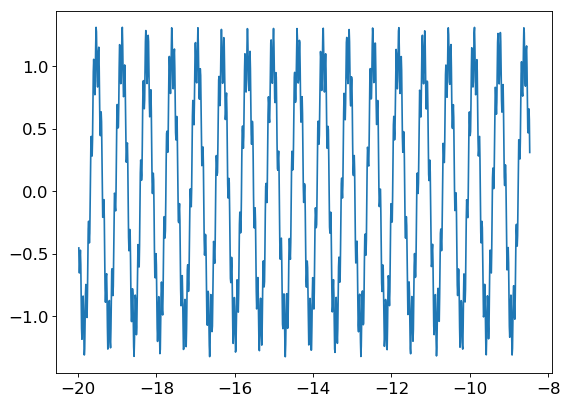

In [248]:
plt.plot(dataPar_x.flatten(), dataPar_y.flatten())

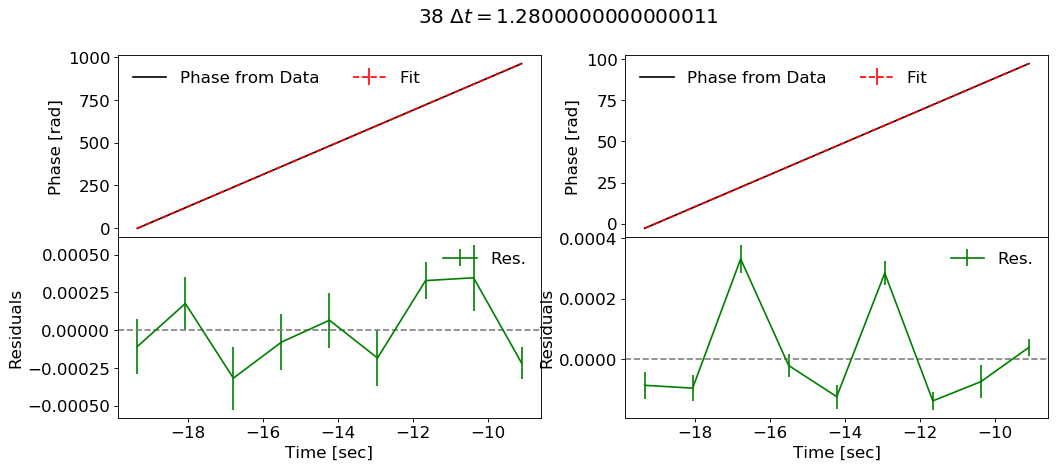

In [249]:
mpl.rcParams['figure.figsize'] = [15.0, 6.0]
f, ax_arr = plt.subplots(2, 2)
f.suptitle(str(k_ind)+' $\Delta t = '+str(dataPar_x[1,0]-dataPar_x[0,0])+"$")
ax_arr[0,0].plot( np.mean(dataPar_x, axis=1), phi1_arr, c="black", label="Phase from Data")
ax_arr[0,0].errorbar( np.mean(dataPar_x, axis=1), phi1_fit[1] + np.mean(dataPar_x, axis=1)*phi1_fit[0], (phi1_err[1]+phi1_err[0]*np.mean(dataPar_x, axis=1)), c="red", ls="--", label="Fit")
ax_arr[1,0].errorbar( np.mean(dataPar_x, axis=1), (phi1_arr - (phi1_fit[1] + np.mean(dataPar_x, axis=1)*phi1_fit[0])), errtout_arr[:,5], c="green", label="Res.")
ax_arr[1,0].axhline(0, ls="--", c="grey")
ax_arr[0,0].legend(frameon=False, ncol=2 )
ax_arr[1,0].legend(frameon=False, ncol=2 )
ax_arr[1,0].set_xlabel("Time [sec]")
ax_arr[0,0].set_ylabel("Phase [rad]")
ax_arr[1,0].set_ylabel("Residuals")
f.subplots_adjust(hspace=0)
ax_arr[0,1].plot( np.mean(dataPar_x, axis=1), phi2_arr, c="black", label="Phase from Data")
ax_arr[0,1].errorbar( np.mean(dataPar_x, axis=1), phi2_fit[1] + np.mean(dataPar_x, axis=1)*phi2_fit[0], (phi2_err[1]+phi2_err[0]*np.mean(dataPar_x, axis=1)), c="red", ls="--", label="Fit")
#ax_arr[0,1].plot( np.mean(dataPar_x, axis=1), phi2_arr[0]+(np.mean(dataPar_x, axis=1)-np.mean(dataPar_x, axis=1)[0])*freq2, ls="-", c="blue", label="$\omega_{fit}t$")
ax_arr[1,1].errorbar( np.mean(dataPar_x, axis=1), (phi2_arr - (phi2_fit[1] + np.mean(dataPar_x, axis=1)*phi2_fit[0])), errtout_arr[:,2], c="green", label="Res.")
ax_arr[1,1].axhline(0, ls="--", c="grey")
ax_arr[0,1].legend(frameon=False, ncol=2 )
ax_arr[1,1].legend(frameon=False, ncol=2 )
ax_arr[1,1].set_xlabel("Time [sec]")
ax_arr[0,1].set_ylabel("Phase [rad]")
ax_arr[1,1].set_ylabel("Residuals")
plt.setp([a.get_xticklabels() for a in [f.axes[1], f.axes[0]]], visible=False)
f.subplots_adjust(hspace=0)

3 44.96323543877188
4 6.646874884164141
5 7.484114390142856


/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in add
  


6 8.043774068909972
7 24.82307312960267
8 38.382506111642485
9 6.84029315320747
10 3.1048974663122015
11 94.21715276056605
12 20.500694673399046


/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


13 37.230489406033044
14 7.42853701376727
15 18.240186408348748
16 28.300115798586123
17 18.371807486067105
18 21.142362760074583
19 28.886814848011873
20 10.470650735076493
21 69.82790044171803
22 89.69910800758738
23 27.431681221100614
24 7.947281067472696
25 14.313490084065515
26 38.28812851966335
27 8.824199504038637
28 9.25543029024612
29 378.6493971707314
30 22.751182301502915
31 87.21570711591295
32 9.313569922934445
33 10.233043597451854
34 112.14268077864351
35 64.23532258059018
36 9.11914075750423
37 25.818481743754987
38 25.1492684469081


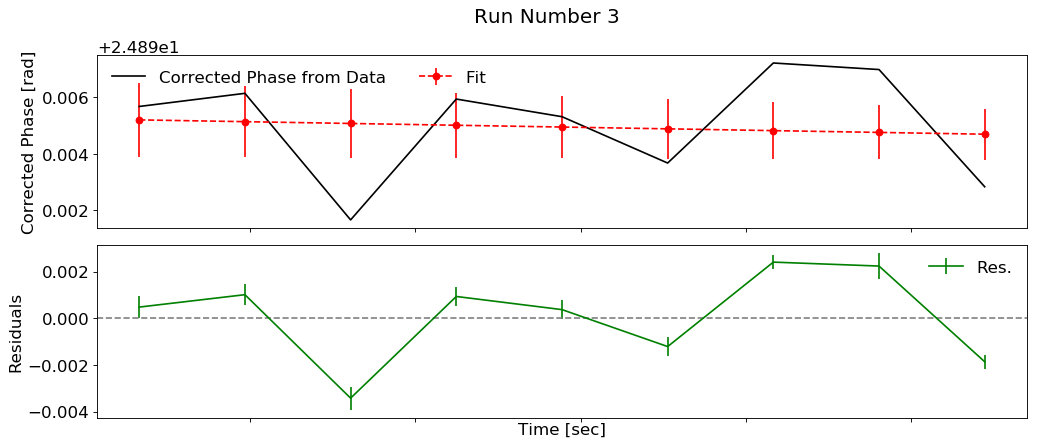

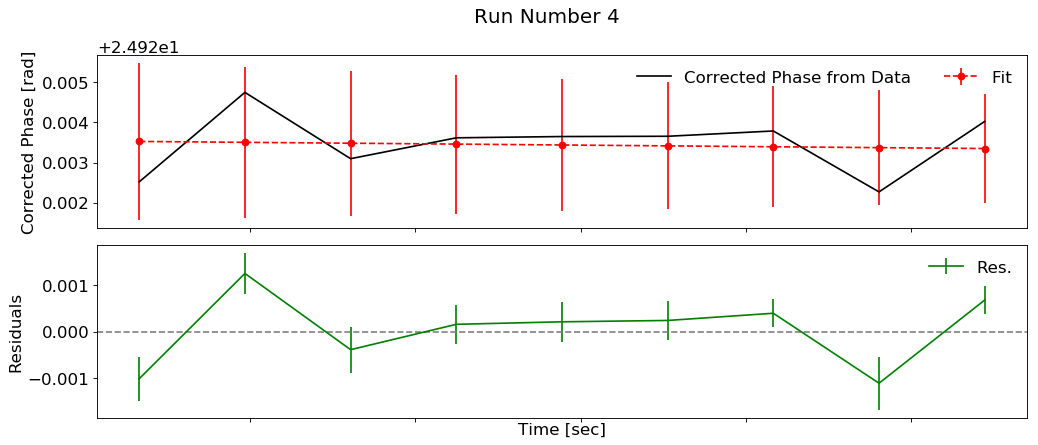

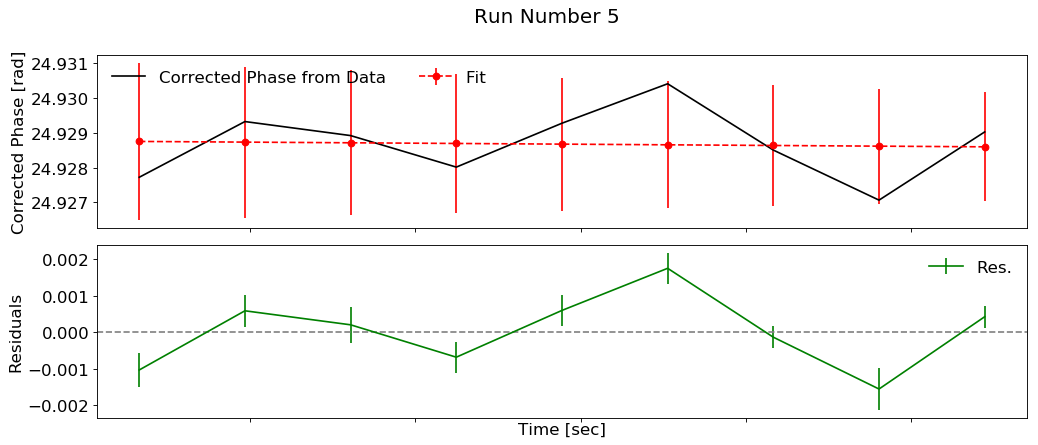

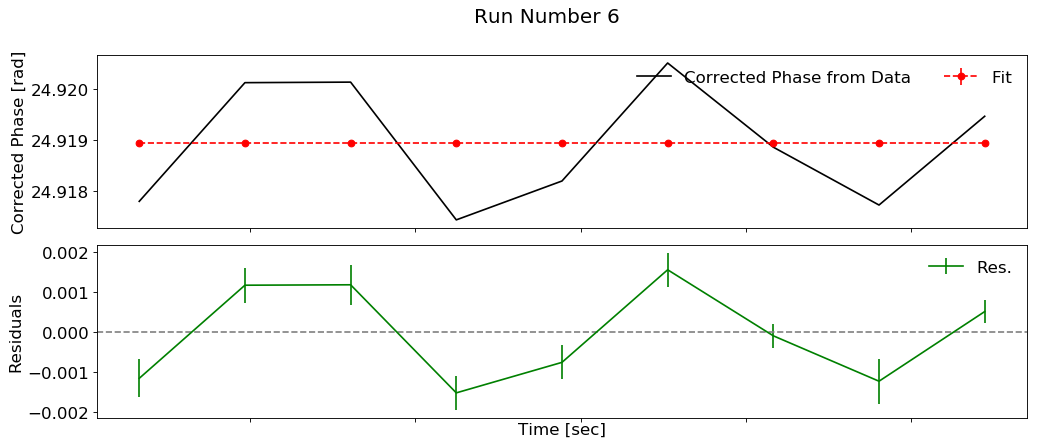

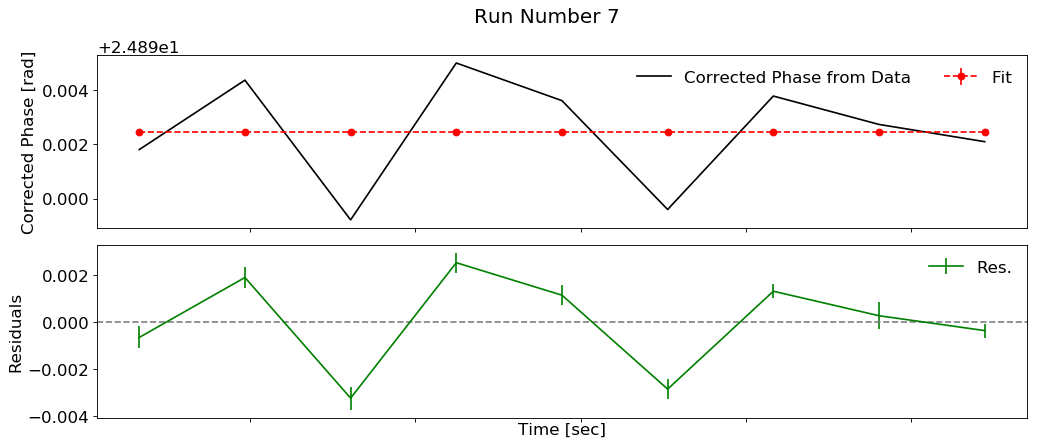

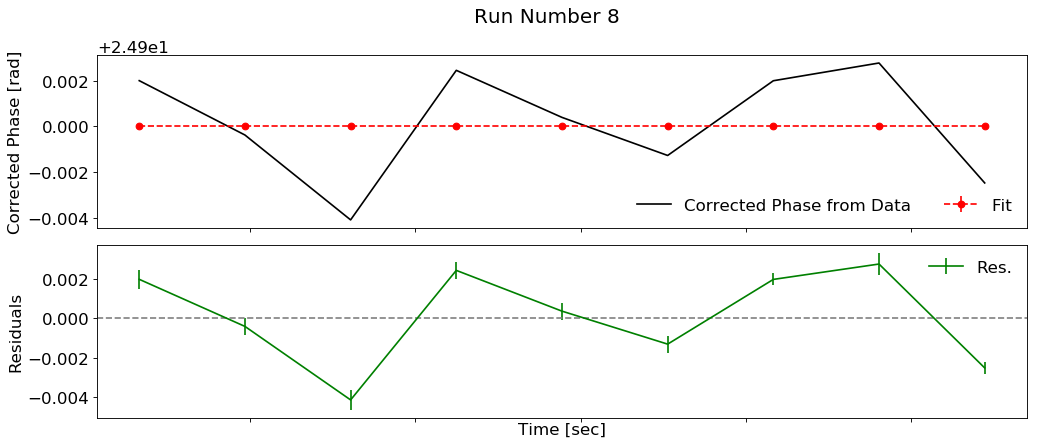

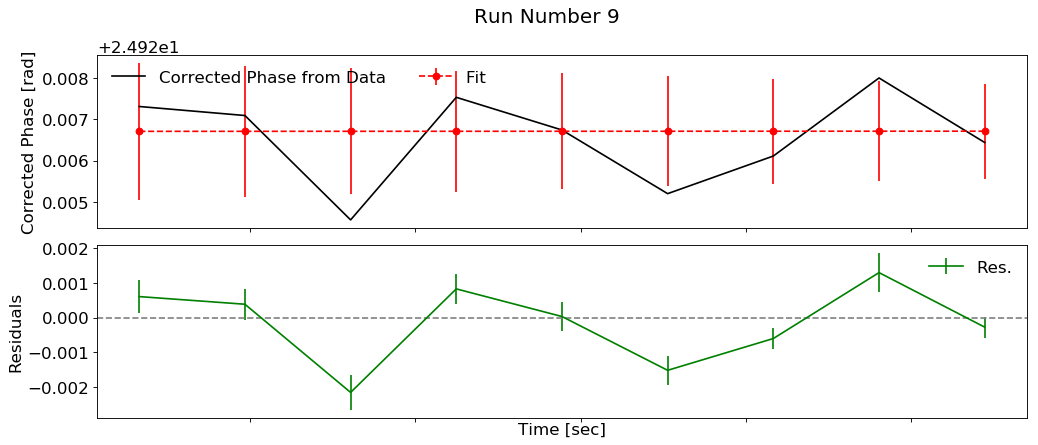

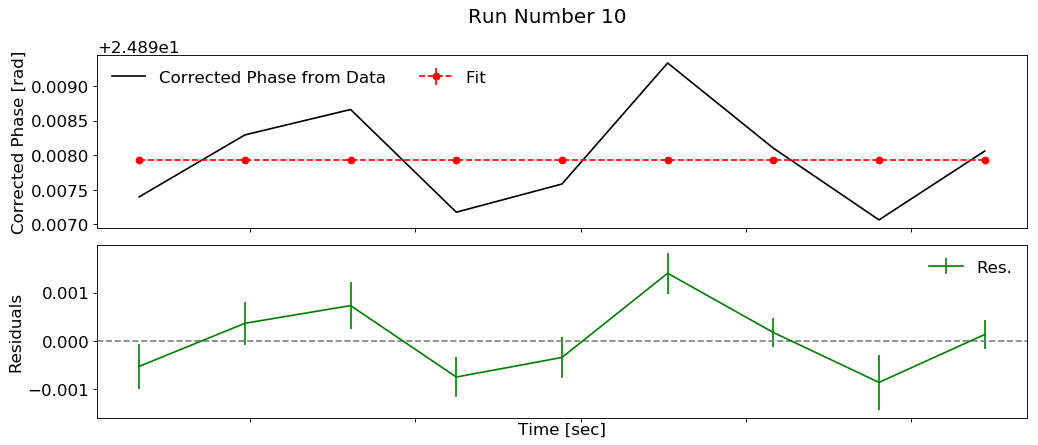

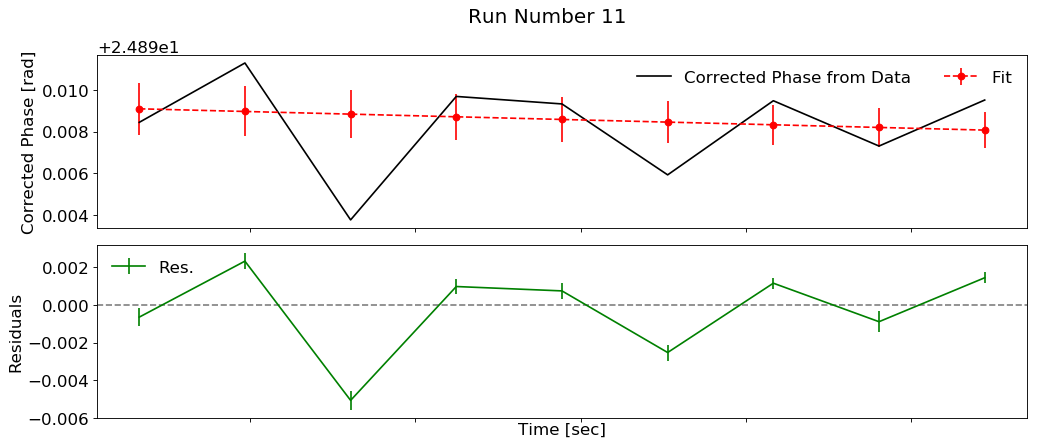

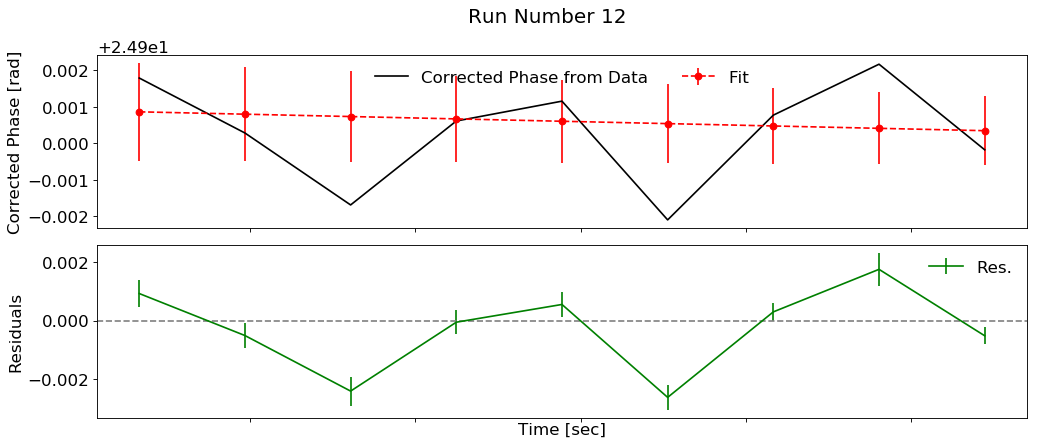

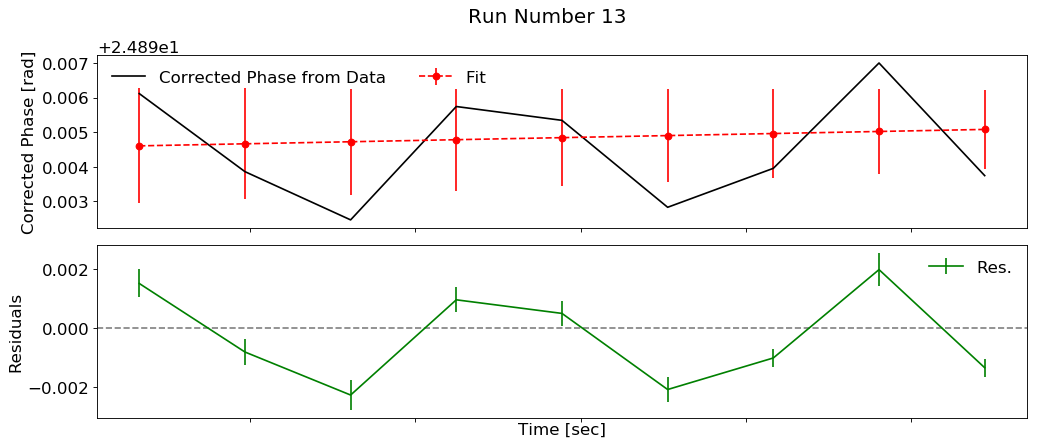

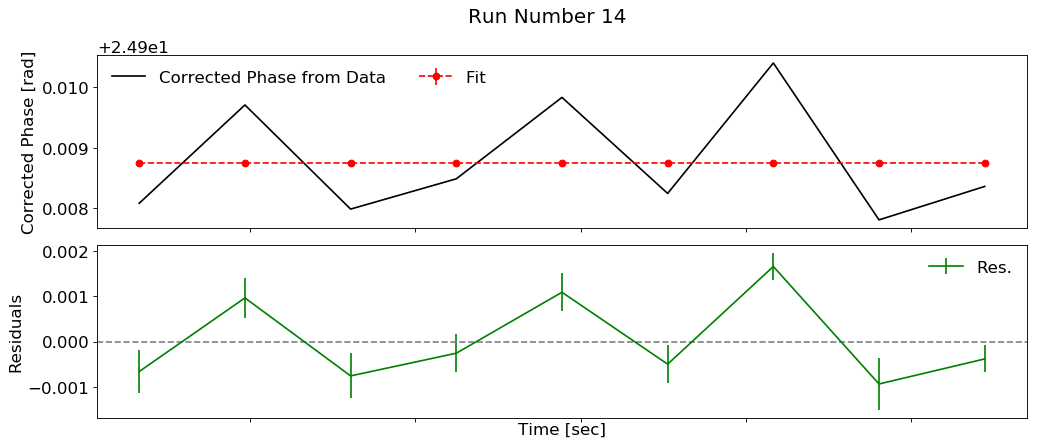

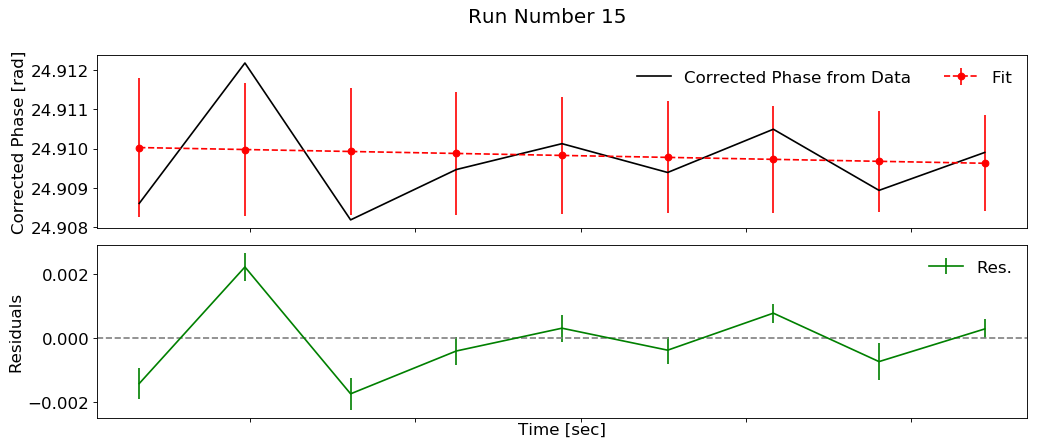

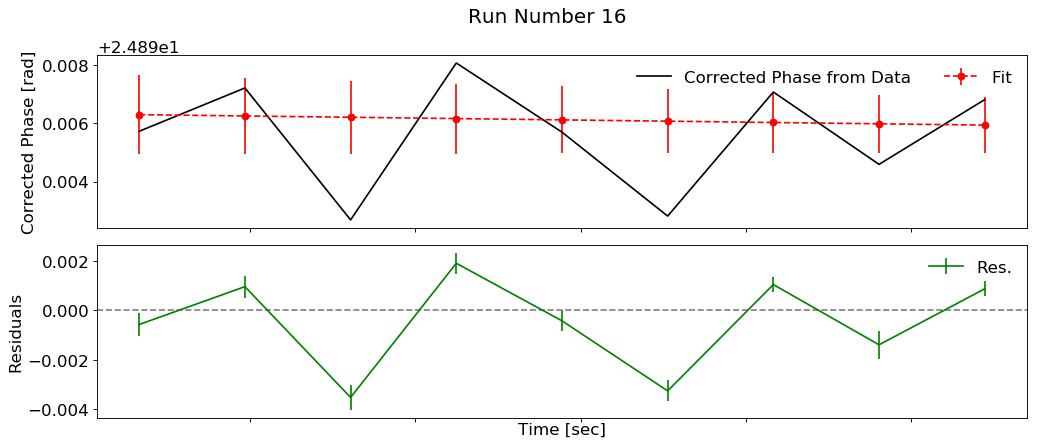

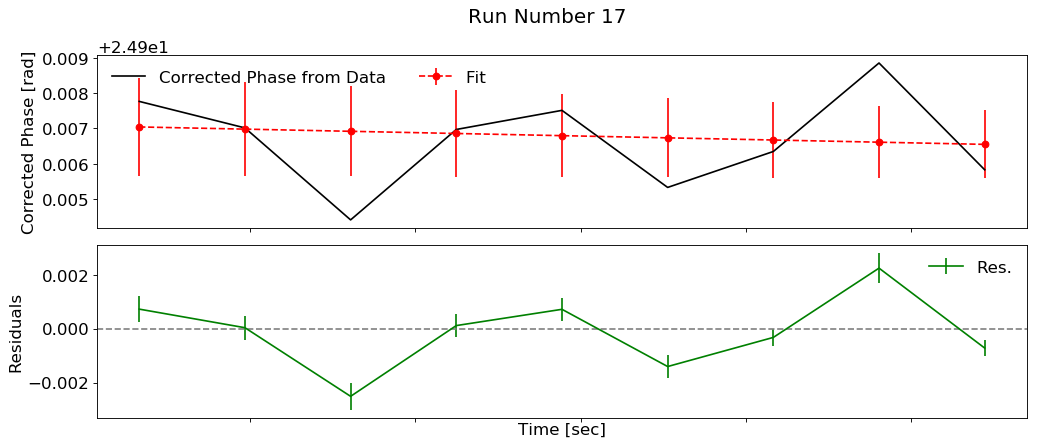

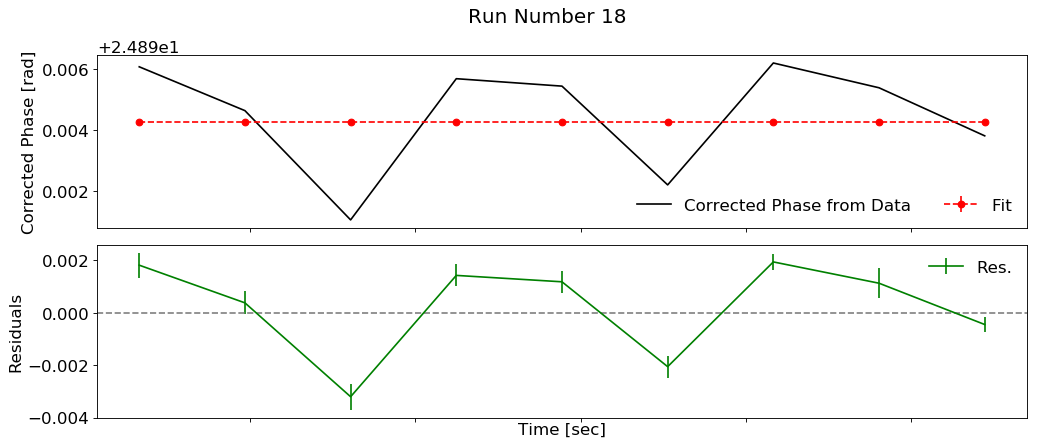

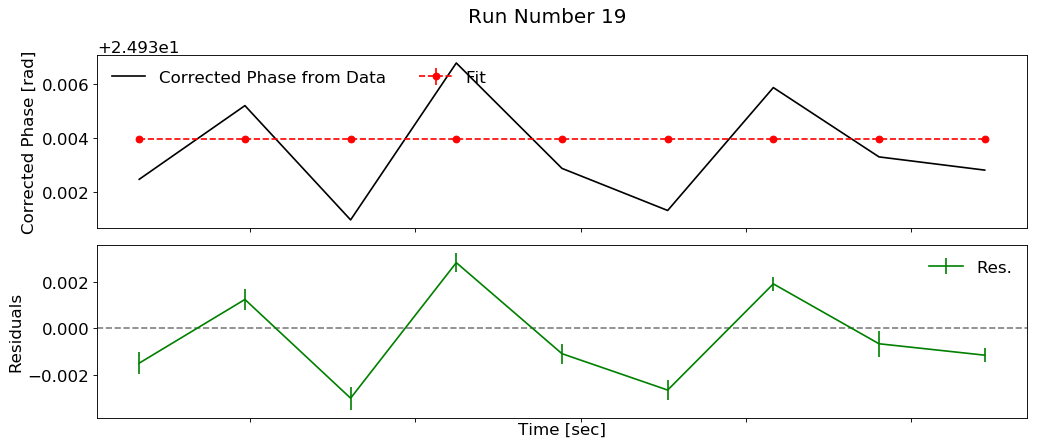

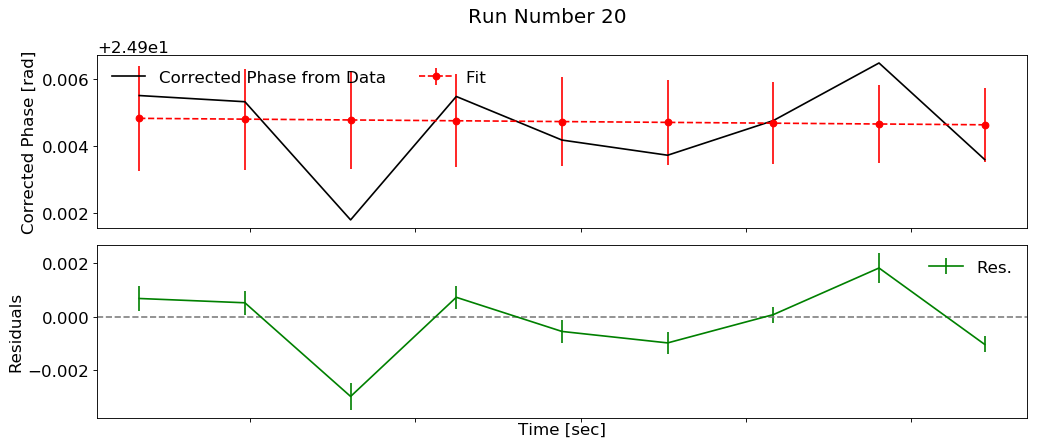

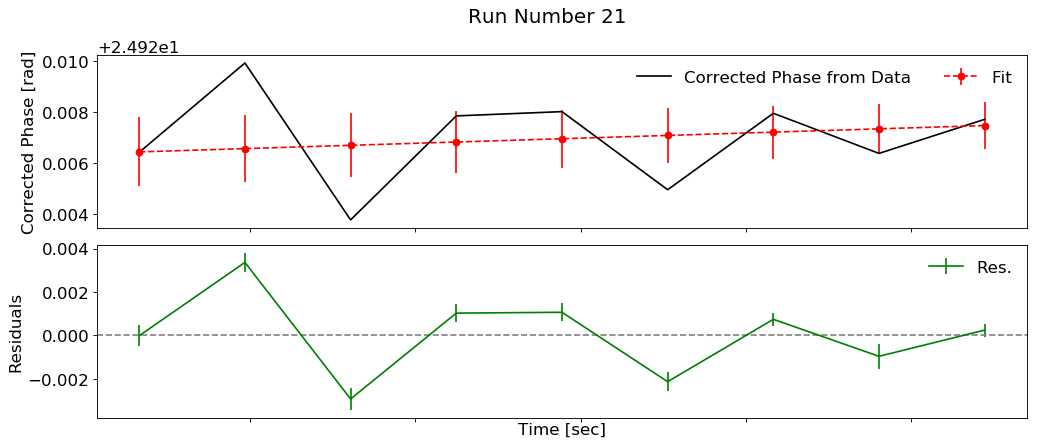

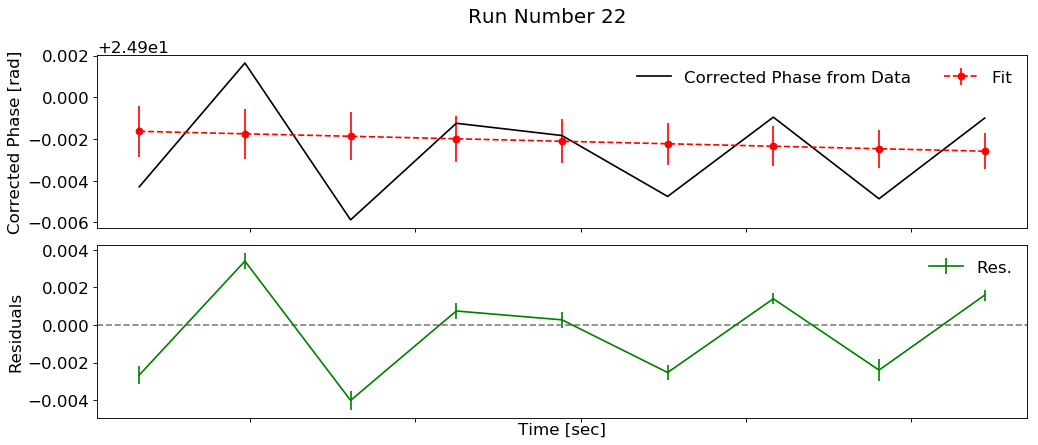

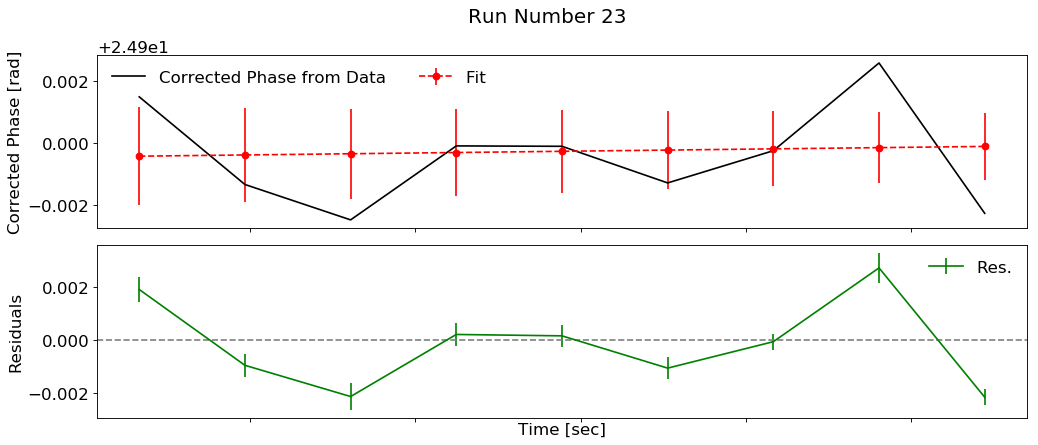

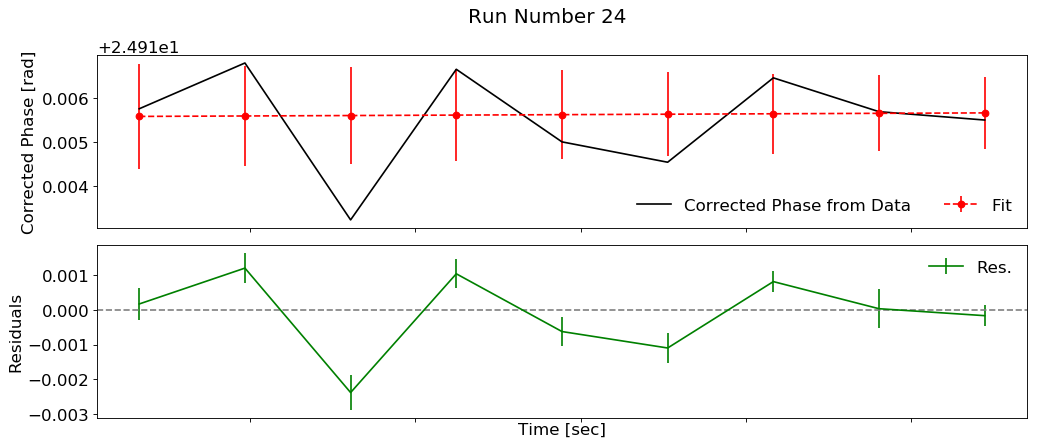

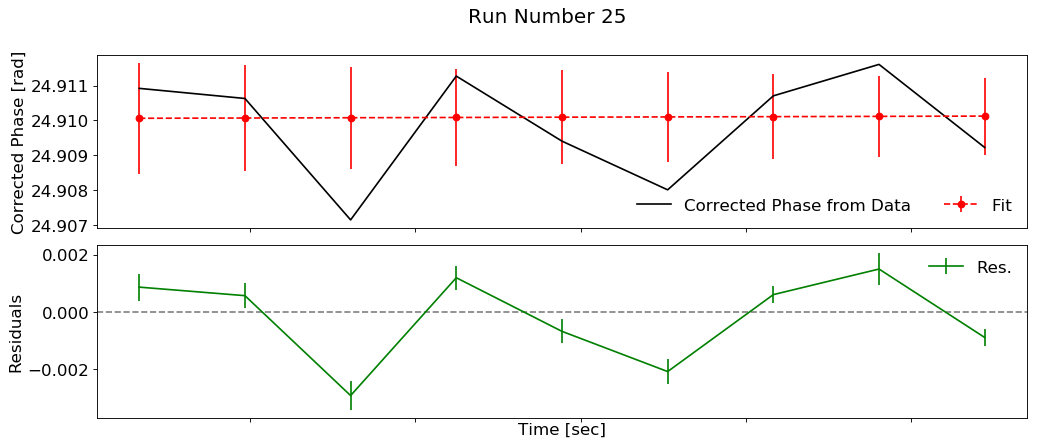

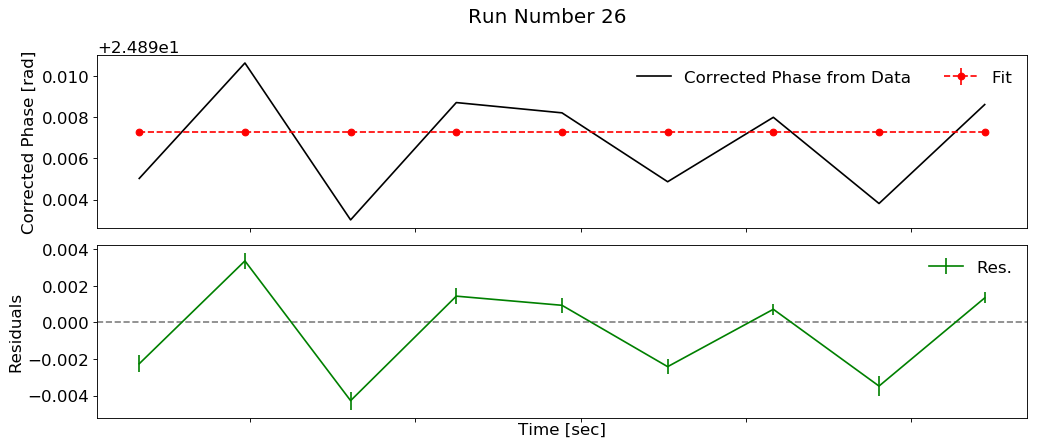

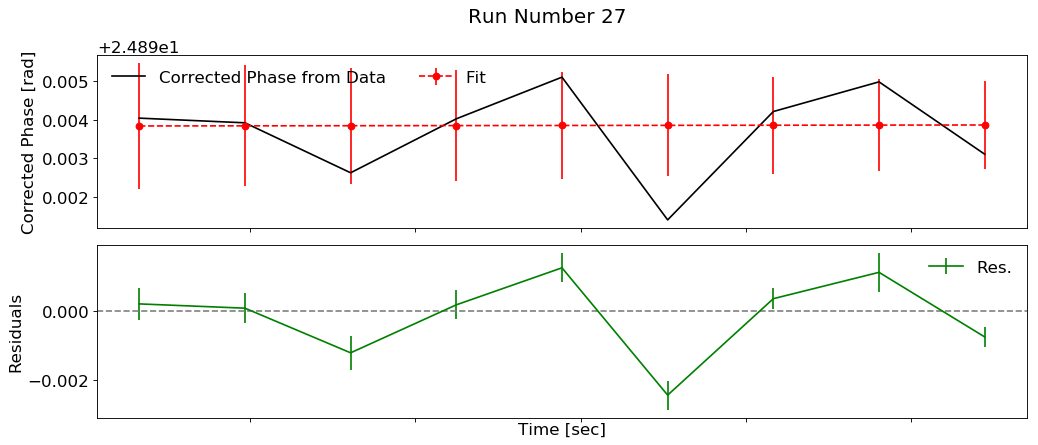

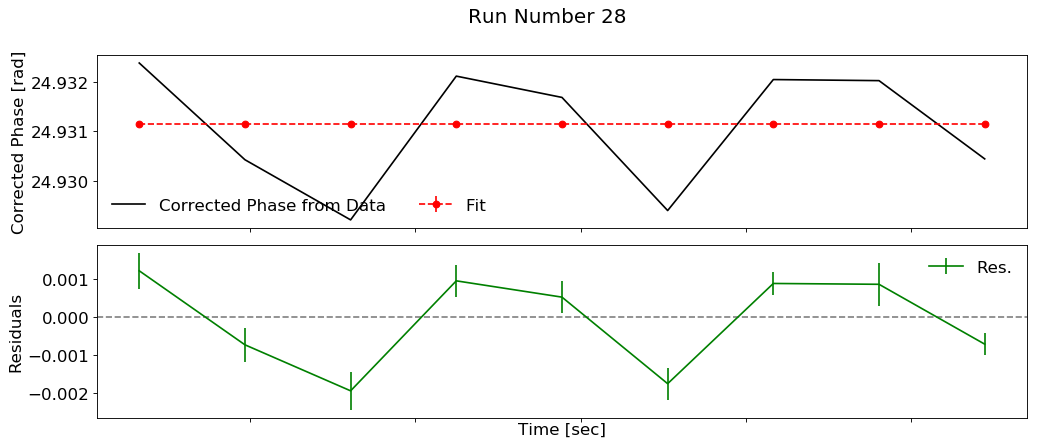

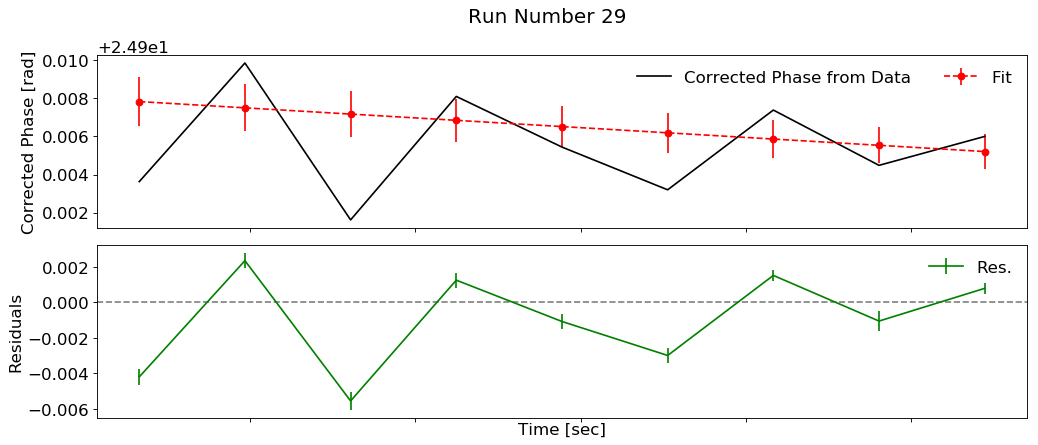

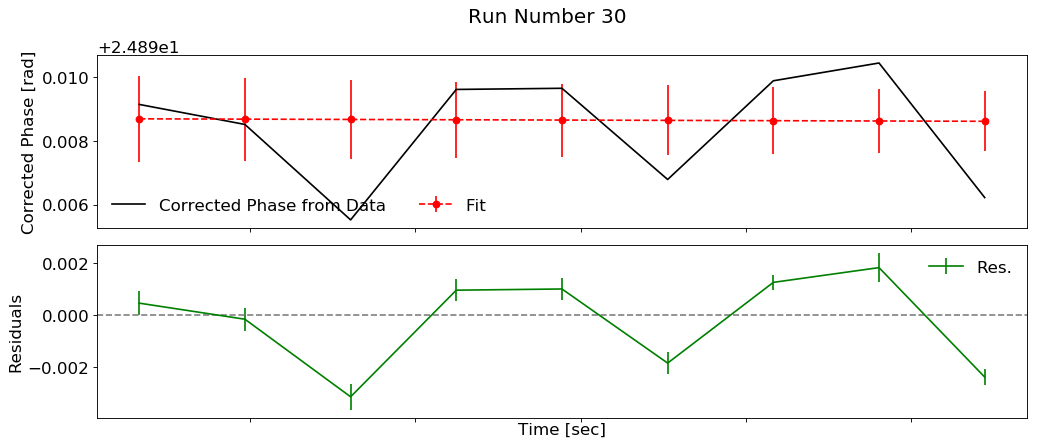

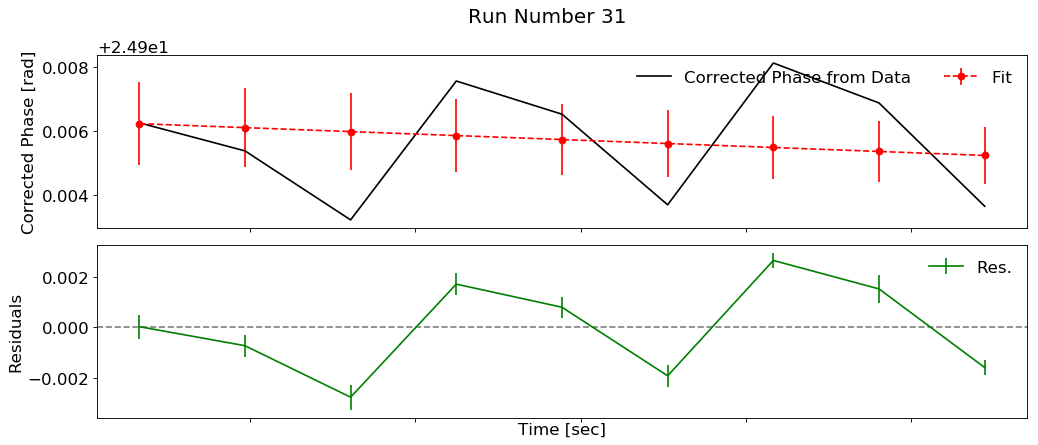

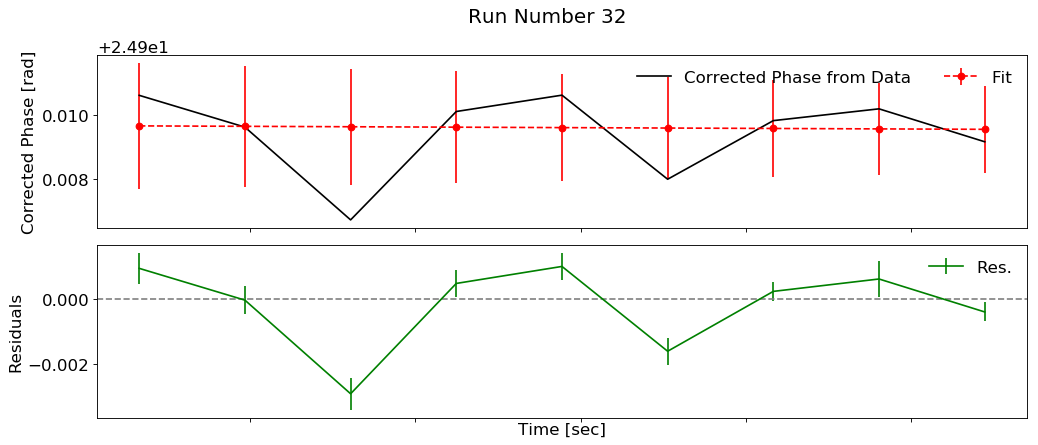

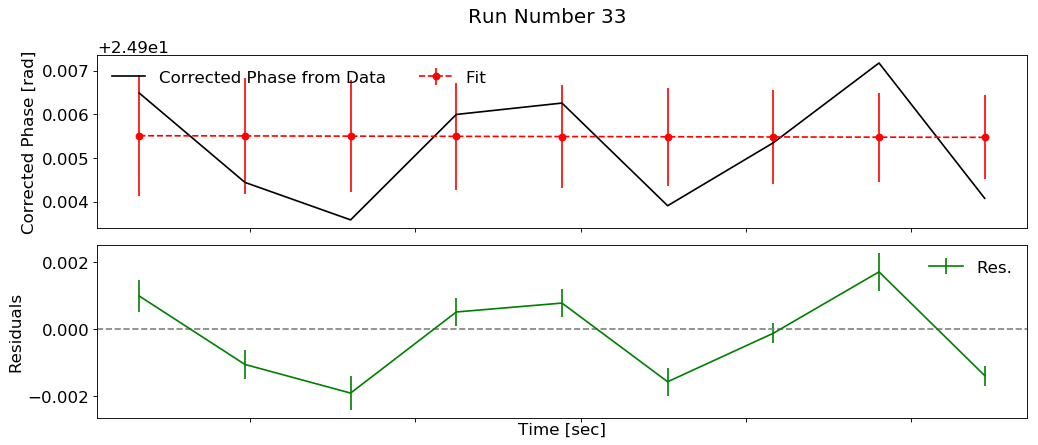

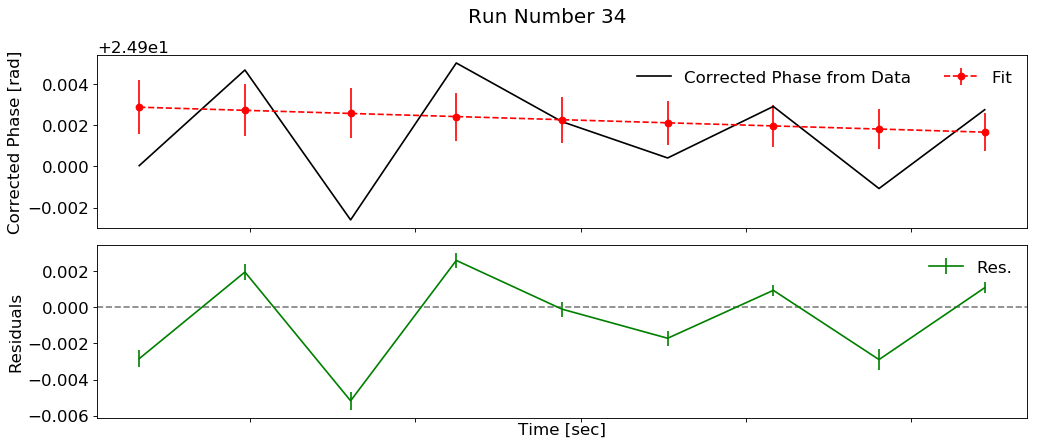

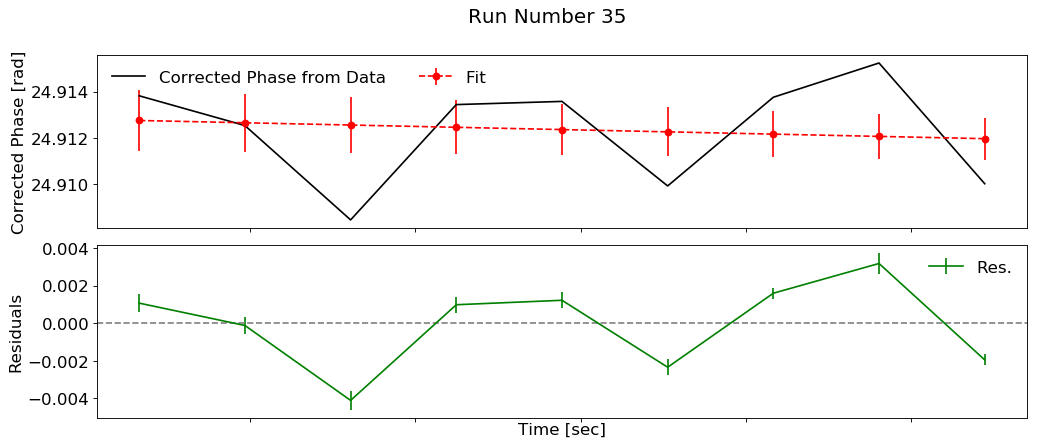

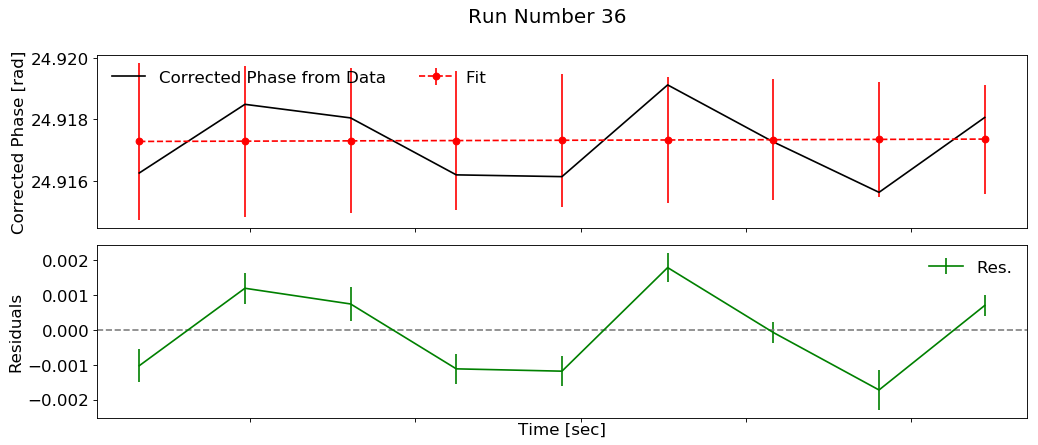

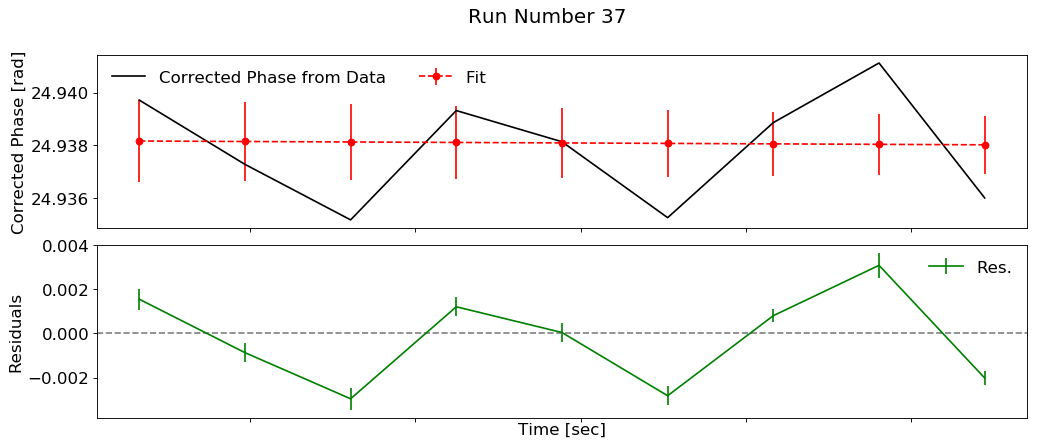

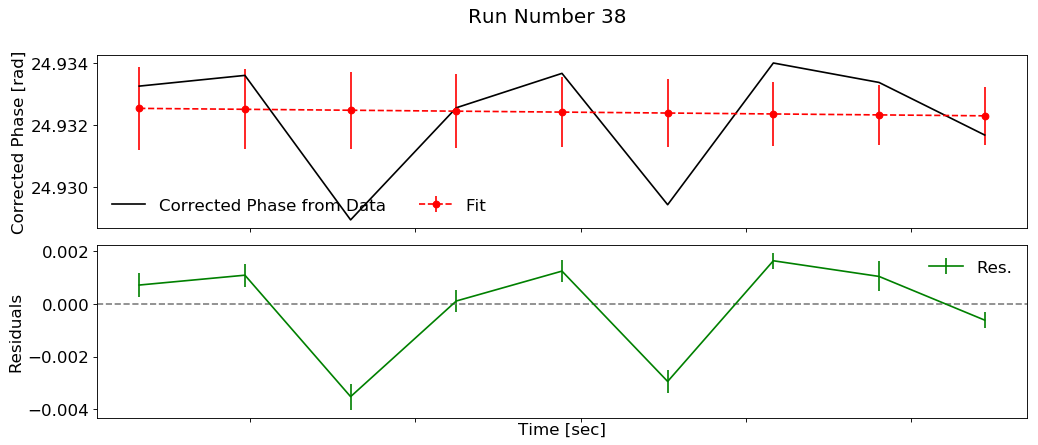

In [259]:
for k_ind in range(ks1, ks2+1):
    i = k_ind - ks1
    #if i>5: continue
    plt.figure();
    f, ax_arr = plt.subplots(2, 1)
    f.suptitle("Run Number " + str(k_ind) )
    ax_arr[0].plot( np.mean(dataPar_x, axis=1), phi1_arr_all[i] - r_arr[i]*phi2_arr_all[i], c="black", label="Corrected Phase from Data")
    ax_arr[0].errorbar( np.mean(dataPar_x, axis=1), corrphase_arr[i][1] + np.mean(dataPar_x, axis=1)*corrphase_arr[i][0], np.amax( (np.abs(corrphaseerr_arr[i][1]+corrphaseerr_arr[i][0]*np.mean(dataPar_x, axis=1)), np.abs(corrphaseerr_arr[i][1]-corrphaseerr_arr[i][0]*np.mean(dataPar_x, axis=1))), axis=0), c="red", ls="--", label="Fit", marker="o")
    ax_arr[1].errorbar( np.mean(dataPar_x, axis=1), (phi1_arr_all[i] - r_arr[i]*phi2_arr_all[i] - (corrphase_arr[i][1] + np.mean(dataPar_x, axis=1)*corrphase_arr[i][0])), (errtout_arr[:,5]**2 + (errtout_arr[:,2]*r)**2)**.5, c="green", label="Res.")
    print(k_ind, np.sum(((phi1_arr_all[i] - r_arr[i]*phi2_arr_all[i] - corrphase_arr[i][1] + np.mean(dataPar_x, axis=1)*corrphase_arr[i][0])/(errtout_arr[:,5]**2 + (errtout_arr[:,2]*r)**2)**.5)**2/(len(phi1_arr_all[i])-2)))
    ax_arr[1].axhline(0, ls="--", c="grey")
    ax_arr[0].legend(frameon=False, ncol=2 )
    ax_arr[1].legend(frameon=False, ncol=2 )
    ax_arr[1].set_xlabel("Time [sec]")
    ax_arr[0].set_ylabel("Corrected Phase [rad]")
    ax_arr[1].set_ylabel("Residuals")
    plt.setp([a.get_xticklabels() for a in [f.axes[1], f.axes[0]]], visible=False)
    f.subplots_adjust(hspace=0.1)

In [251]:
        # Make some plots
#         plt.figure()
#         plt.plot(dataPar_x.flatten(), (dataPar_y).flatten())
#         plt.plot(dataPar_x.flatten(), datafit2, ls="--")
#         plt.plot(dataPar_x.flatten(), 100*(datafit2-(dataPar_y).flatten())-1.5)
#         mpl.rcParams['figure.figsize'] = [15.0, 6.0]
#         f, ax_arr = plt.subplots(2, 2)
#         f.suptitle(str(k_ind)+' $\Delta t = '+str(dataPar_x[1,0]-dataPar_x[0,0])+"$, $N_1="+str(N1)+"$, $N_2="+str(N2)+"$")
#         ax_arr[0,0].plot( np.mean(dataPar_x, axis=1), phi1_arr, c="black", label="Phase from Data")
#         ax_arr[0,0].errorbar( np.mean(dataPar_x, axis=1), phi1_fit[1] + np.mean(dataPar_x, axis=1)*phi1_fit[0], (phi1_err[1]+phi1_err[0]*np.mean(dataPar_x, axis=1)), c="red", ls="--", label="Fit")
#         ax_arr[0,0].plot( np.mean(dataPar_x, axis=1), phi1_arr[0]+(np.mean(dataPar_x, axis=1)-np.mean(dataPar_x, axis=1)[0])*freq1, ls="-", c="blue", label="$\omega_{fit}t$")
#         ax_arr[1,0].plot( np.mean(dataPar_x, axis=1), (phi1_arr - (phi1_fit[1] + np.mean(dataPar_x, axis=1)*phi1_fit[0])), c="green", label="Res.")
#         ax_arr[1,0].axhline(0, ls="--", c="grey")
#         ax_arr[0,0].legend(frameon=False, ncol=2 )
#         ax_arr[1,0].legend(frameon=False, ncol=2 )
#         ax_arr[1,0].set_xlabel("Time [sec]")
#         ax_arr[0,0].set_ylabel("Phase [rad]")
#         ax_arr[1,0].set_ylabel("Residuals")
#         f.subplots_adjust(hspace=0)

#         ax_arr[0,1].plot( np.mean(dataPar_x, axis=1), phi2_arr, c="black", label="Phase from Data")
#         ax_arr[0,1].errorbar( np.mean(dataPar_x, axis=1), phi2_fit[1] + np.mean(dataPar_x, axis=1)*phi2_fit[0], (phi2_err[1]+phi2_err[0]*np.mean(dataPar_x, axis=1)), c="red", ls="--", label="Fit")
#         ax_arr[0,1].plot( np.mean(dataPar_x, axis=1), phi2_arr[0]+(np.mean(dataPar_x, axis=1)-np.mean(dataPar_x, axis=1)[0])*freq2, ls="-", c="blue", label="$\omega_{fit}t$")
#         ax_arr[1,1].plot( np.mean(dataPar_x, axis=1), (phi2_arr - (phi2_fit[1] + np.mean(dataPar_x, axis=1)*phi2_fit[0])), c="green", label="Res.")
#         ax_arr[1,1].axhline(0, ls="--", c="grey")
#         ax_arr[0,1].legend(frameon=False, ncol=2 )
#         ax_arr[1,1].legend(frameon=False, ncol=2 )
#         ax_arr[1,1].set_xlabel("Time [sec]")
#         ax_arr[0,1].set_ylabel("Phase [rad]")
#         ax_arr[1,1].set_ylabel("Residuals")
#         plt.setp([a.get_xticklabels() for a in [f.axes[1], f.axes[0]]], visible=False)
#         f.subplots_adjust(hspace=0)

#         plt.figure();
#         f, ax_arr = plt.subplots(2, 1)
#         f.suptitle(str(k_ind))
#         ax_arr[0].errorbar( (np.mean(dataPar_x, axis=1)[:-1]+np.mean(dataPar_x, axis=1)[1:])/2, (phi1_arr[1:]-phi1_arr[:-1])/(dataPar_x[1,0]-dataPar_x[0,0]), np.sqrt(errtout_arr[1:,5]**2+errtout_arr[:-1,5]**2)/(dataPar_x[1,0]-dataPar_x[0,0]), label="$\\frac{\\Delta \\phi}{\\Delta t}$", c="black", ls="--", fmt='o', markersize=8, capsize=8)
#         ax_arr[0].axhline(phi1_fit[0], ls="--", c="grey", label="$\omega_{fit}$")
#         ax_arr[1].errorbar(  (np.mean(dataPar_x, axis=1)[:-1]+np.mean(dataPar_x, axis=1)[1:])/2, (phi2_arr[1:]-phi2_arr[:-1])/(dataPar_x[1,0]-dataPar_x[0,0]), np.sqrt(errtout_arr[1:,2]**2+errtout_arr[:-1,2]**2)/(dataPar_x[1,0]-dataPar_x[0,0]), label="$\\frac{\\Delta \\phi}{\\Delta t}$", c="black", ls="--", fmt='o', markersize=8, capsize=8)
#         ax_arr[1].axhline(phi2_fit[0], ls="--", c="grey", label="$\omega_{fit}$")
#         ax_arr[0].set_ylabel("$\\frac{\\Delta \\phi}{\\Delta t}$ [rad s$^{-1}$]")
#         ax_arr[1].set_ylabel("$\\frac{\\Delta \\phi}{\\Delta t}$ [rad s$^{-1}$]")
#         plt.setp([a.get_xticklabels() for a in [f.axes[0]]], visible=False)
#         f.subplots_adjust(hspace=0)
#         ax_arr[1].set_xlabel("Time [sec]")
#         ax_arr[0].legend()
#         ax_arr[1].legend()

#         plt.figure();
#         f, ax_arr = plt.subplots(2, 1)
#         f.suptitle(str(k_ind))
#         ax_arr[0].errorbar(np.mean(dataPar_x, axis=1)[1:], np.array(fit_freq1)/(2*np.pi), fit_err1, label="$\omega_1(t)$", c="black", ls="--", fmt='o', markersize=8, capsize=8)
#         ax_arr[0].axhline(phi1_fit[0]/(2*np.pi), ls="--", c="grey", label="$\omega_{fit}$")
#         ax_arr[1].errorbar(np.mean(dataPar_x, axis=1)[1:], np.array(fit_freq2)/(2*np.pi), fit_err2, label="$\omega_2(t)$", c="black", ls="--", fmt='o', markersize=8, capsize=8)
#         ax_arr[1].axhline(phi2_fit[0]/(2*np.pi), ls="--", c="grey", label="$\omega_{fit}$")
#         ax_arr[0].set_ylabel("$\omega$ [Hz]")
#         ax_arr[1].set_ylabel("$\omega$ [Hz]")
#         plt.setp([a.get_xticklabels() for a in [f.axes[0]]], visible=False)
#         f.subplots_adjust(hspace=0.1)
#         ax_arr[1].set_xlabel("Time [sec]")
#         ax_arr[0].legend()
#         ax_arr[1].legend()

#         print('-------------------', n_subs, '-------------------')
#         print(phi1_fit[0]/2/np.pi, phi2_fit[0]/2/np.pi)
#         print(freq1/2/np.pi, freq2/2/np.pi)

Text(0.5,0,'Run Number')

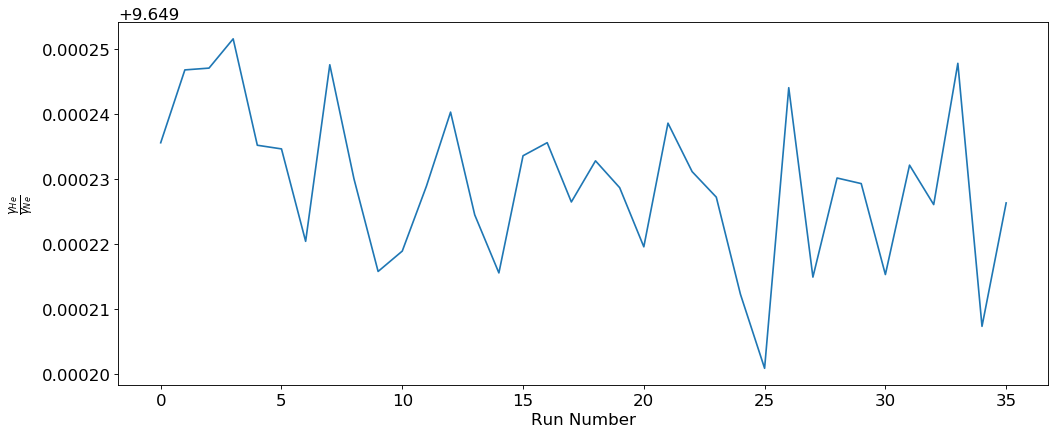

In [256]:
plt.plot(r_arr)
#plt.axhline(gHe/gNe)
plt.ylabel("$\\frac{\\gamma_{He}}{\\gamma_{Ne}}$")
plt.xlabel("Run Number")

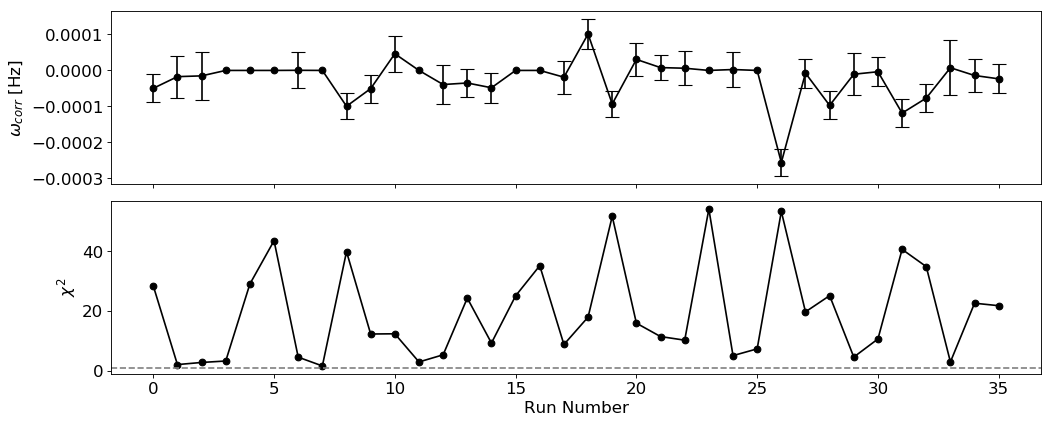

In [255]:
# plt.figure()
# plt.ylabel("Corrected Frequency [Hz]")
# plt.xlabel("Run Number")
# plt.errorbar(np.arange(len(fout)), fout[:,0] - gHe/gNe*fout[:,1], np.sqrt(ferr[:,0]**2 + (ferr[:,1]*gHe/gNe)**2), fmt="o", ls="-", c="black", markersize=6, capsize=6)
# plt.figure()
# plt.ylabel("Frequency Ratio")
# plt.xlabel("Run Number")
# plt.errorbar(np.arange(len(fout)), fout[:,0]/fout[:,1], fout[:,0]/fout[:,1]*np.sqrt((ferr[:,0]/fout[:,0])**2 + (ferr[:,1]/fout[:,1])**2), fmt="o", ls="-", c="black", markersize=6, capsize=6)
# plt.figure()
# f, ax_arr = plt.subplots(2, 1)
# ax_arr[0].errorbar(np.arange(len(fout)), fout[:,0]/(2*np.pi), ferr[:,0]/(2*np.pi), fmt="o", ls="-", c="black", markersize=6, capsize=6)
# ax_arr[0].set_ylabel("$\omega$ [Hz]")
# ax_arr[1].plot(np.arange(len(fout)), chi2[:,0], marker=".", markersize=12, color="black")
# ax_arr[1].set_ylabel("$\chi^2$")
# ax_arr[1].set_xlabel("Run Number")
# ax_arr[1].axhline(1, ls="--", c="grey")
# #ax_arr[1].set_yscale("log")
# plt.setp([a.get_xticklabels() for a in [f.axes[0]]], visible=False)
# f.subplots_adjust(hspace=0.1)
# plt.figure()
# f, ax_arr = plt.subplots(2, 1)
# ax_arr[0].errorbar(np.arange(len(fout)), fout[:,1]/(2*np.pi), ferr[:,1]/(2*np.pi), fmt="o", ls="-", c="black", markersize=6, capsize=6)
# ax_arr[0].set_ylabel("$\omega$ [Hz]")
# ax_arr[1].plot(np.arange(len(fout)), chi2[:,1], marker=".", markersize=12, color="black")
# ax_arr[1].set_ylabel("$\chi^2$")
# ax_arr[1].set_xlabel("Run Number")
# ax_arr[1].axhline(1, ls="--", c="grey")
# #ax_arr[1].set_yscale("log")
# plt.setp([a.get_xticklabels() for a in [f.axes[0]]], visible=False)
# f.subplots_adjust(hspace=0.1)
f, ax_arr = plt.subplots(2, 1)
ax_arr[0].errorbar(np.arange(len(corrphase_arr)), corrphase_arr[:,0], corrphaseerr_arr[:,0], fmt="o", ls="-", c="black", markersize=6, capsize=6)
ax_arr[0].set_ylabel("$\omega_{corr}$ [Hz]")
ax_arr[1].plot(np.arange(len(corrphase_arr)), corrphasechi2_arr, marker=".", markersize=12, color="black")
ax_arr[1].set_ylabel("$\chi^2$")
ax_arr[1].set_xlabel("Run Number")
ax_arr[1].axhline(1, ls="--", c="grey")
#ax_arr[1].set_yscale("log")
plt.setp([a.get_xticklabels() for a in [f.axes[0]]], visible=False)
f.subplots_adjust(hspace=0.1)
#ax_arr[1].set_ylim(0,10)

Text(0.5,1,'$\\omega_{corr} \\, \\chi^2$ histogram')

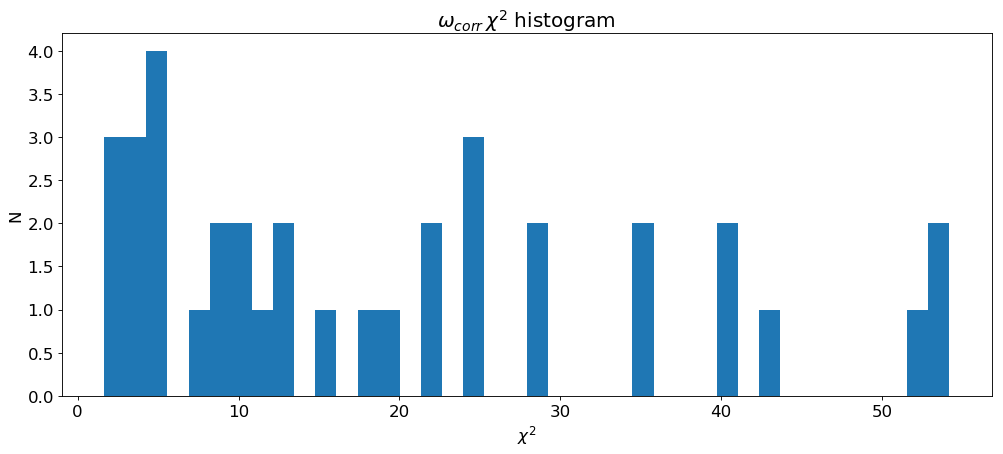

In [254]:
plt.hist(corrphasechi2_arr, bins=40)
plt.xlabel("$\chi^2$")
plt.ylabel("N")
plt.title("$\omega_{corr} \, \chi^2$ histogram")